In [1]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from datetime import datetime

In [2]:
import tensorflow as tf
from numba import cuda

# Code to make tensors run on GPU
def set_gpu_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

def clear_gpu_memory():
    # This part may not be necessary, as TensorFlow manages GPU memory automatically
    pass

# Calling the function to set GPU device
set_gpu_device()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("No GPU found. TensorFlow will use the CPU.")


GPU is available!


In [3]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
train_data_path= pathlib.Path('new_dataset/train/')
test_data_path = pathlib.Path('new_dataset/test/')
valid_data_path = pathlib.Path('new_dataset/valid/')

In [5]:
# Set image size, batch size, sample number and epochs

img_rows = 150
img_cols = 150
epochs = 100
batch_size = 32
num_of_train_samples = 7657 
num_of_valid_samples = 3020


############################################
# Set Data Generator for training, testing and validataion.
# Note for testing, set shuffle = false (For proper Confusion matrix)

 # This will do preprocessing and realtime data augmentation:
 # this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=15, # randomly rotate images in the range 
                                                      # (degrees, 0 to 40)
                                   width_shift_range=0.1, # randomly shift images horizontally 
                                                          # (fraction of total width)
                                   height_shift_range=0.1,# randomly shift images vertically 
                                                          # (fraction of total height)
                                   shear_range=10, #shear_range is for randomly applying shearing transformations
                                   zoom_range=0.15, #randomly zooming inside pictures
                                   horizontal_flip=True, # randomly flip images
                                   fill_mode='nearest')

# batches of augmented image data
train_generator = train_datagen.flow_from_directory(train_data_path, # this is the target directory
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
valid_datagen = ImageDataGenerator(rescale=1. / 255)
                                                    
# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(valid_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='categorical')
                                                        
 # this is a similar generator, for test data                                                       
test_generator = test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size,
                                                        shuffle=False,
                                                        class_mode='categorical')

Found 7657 images belonging to 14 classes.
Found 3020 images belonging to 14 classes.
Found 3029 images belonging to 14 classes.


## Densnet on original dataset

In [6]:
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras import backend as K

def create_densenet121(learn_rate=0.0001, num_classes=14, dense_neurons=512, activation='softmax', l2_reg=0.01):
    K.clear_session()
    # configure model and training parameters
    image_size = 224
    optimizer = Adam(lr=learn_rate)

    # Load the densenet model initialized to imagenet
    denseN = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    model_3 = Sequential()
    model_3.add(denseN)
    model_3.add(GlobalAveragePooling2D())
    model_3.add(Dense(dense_neurons, activation='relu', kernel_regularizer=l2(l2_reg)))
    model_3.add(BatchNormalization())
    model_3.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model_3.add(BatchNormalization())
    model_3.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    model_3.add(BatchNormalization())
    model_3.add(Dense(num_classes, activation=activation))

    # unfreeze all layers
    for layer in model_3.layers:
        layer.trainable = True

    model_3.summary()

    return model_3

In [7]:
model_3 = create_densenet121()

c:\Users\sudha\py10\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

Testing for 100 epoch on original dataset with the best model

I made some changes for early stopings since i would be running this overnight

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Specify the path where you want to save the model weights
checkpoint_path = 'densenet121_original_dataset_early_stopping.h5'

#  early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,          
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',  
    mode='min',
    verbose=1
)

# Compile the model
model_3.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

# Train the model with early stopping
history = model_3.fit(
    train_generator,
    steps_per_epoch=num_of_train_samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=num_of_valid_samples // batch_size,
    callbacks=[early_stopping, model_checkpoint] 
)


Epoch 1/100
239/239 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.7625
Epoch 1: val_loss improved from inf to 3.21797, saving model to densenet121_original_dataset_early_stopping.h5
239/239 [==============================] - 137s 520ms/step - loss: 1.0530 - accuracy: 0.7625 - val_loss: 3.2180 - val_accuracy: 0.3936
Epoch 2/100
239/239 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.7961
Epoch 2: val_loss improved from 3.21797 to 1.46856, saving model to densenet121_original_dataset_early_stopping.h5
239/239 [==============================] - 121s 506ms/step - loss: 0.9032 - accuracy: 0.7961 - val_loss: 1.4686 - val_accuracy: 0.6835
Epoch 3/100
239/239 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.8134
Epoch 3: val_loss did not improve from 1.46856
239/239 [==============================] - 119s 496ms/step - loss: 0.8251 - accuracy: 0.8134 - val_loss: 2.3552 - val_accuracy: 0.5416
Epoch 4/100
239/239 [==========

In [15]:
# # Specify the path where you want to save the model weights
# checkpoint_path = 'densenet121_original_dataset_100.h5'

# # Compile the model
# model_3.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

# # Train the model
# history = model_3.fit(
#     train_generator,
#     steps_per_epoch=num_of_train_samples // batch_size,
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=num_of_valid_samples // batch_size
# )

# # Save the model
# model_3.save(checkpoint_path)

94/94 [==============================] - 85s 915ms/step - loss: 0.6173 - accuracy: 0.8630
Test Accuracy: 86.30%


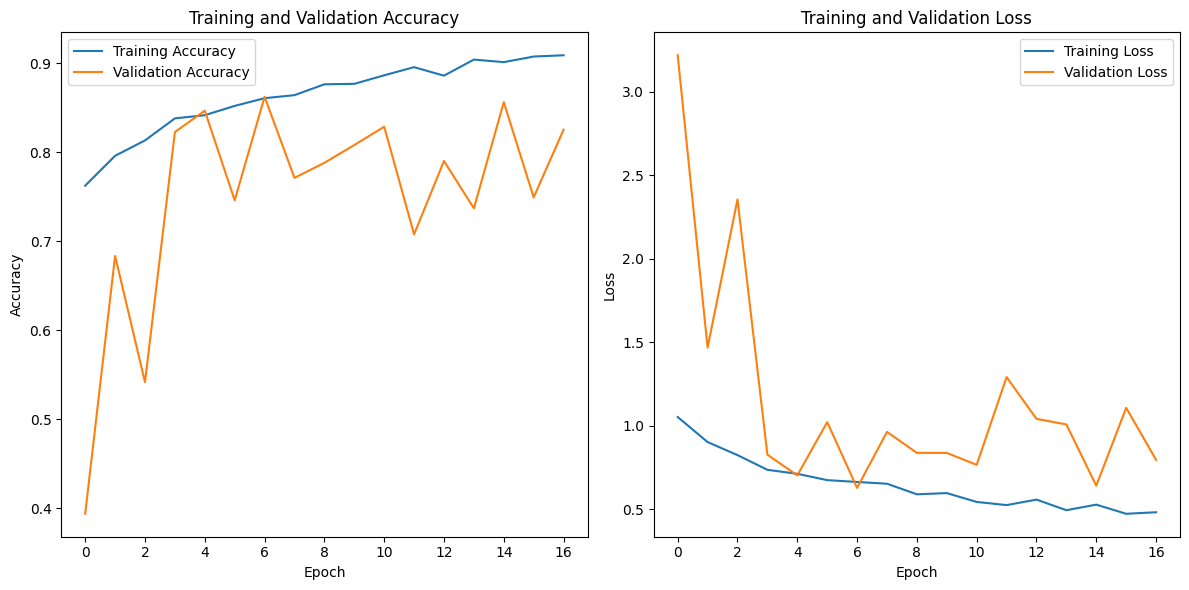

In [10]:
# Evaluate the model on the test data
test_steps = num_of_valid_samples // batch_size
evaluation = model_3.evaluate(test_generator, steps=test_steps)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [11]:
# Predict the classes for the entire test set
y_pred = model_3.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels for the entire test set
y_true_classes = test_generator.classes

# Generate and print the classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=train_generator.class_indices)
print("Classification Report:\n", class_report)


95/95 [==============================] - 27s 272ms/step
Classification Report:
               precision    recall  f1-score   support

Amur_Leopard       0.85      0.58      0.69       199
  Arctic_Fox       0.91      0.87      0.89       135
  Chimpanzee       0.98      0.77      0.86       166
     Jaguars       0.65      0.88      0.75       209
        Lion       0.91      0.80      0.85       271
   Orangutan       0.99      0.87      0.93       179
       Panda       0.99      0.82      0.89       280
    Panthers       0.76      0.94      0.84       200
       Rhino       0.80      0.93      0.86       259
      belgua       0.99      1.00      0.99       230
    cheetahs       0.69      0.93      0.79       211
       heyna       0.96      0.83      0.89       230
     leopard       0.85      0.88      0.87       230
  whaleshark       1.00      0.98      0.99       230

    accuracy                           0.86      3029
   macro avg       0.88      0.86      0.86      3029


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes for the entire test set
y_pred = model_3.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels for the entire test set
y_true_classes = test_generator.classes

# Find misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


95/95 [==============================] - 25s 262ms/step


In [17]:
print(conf_matrix)

[[116   0   0  71   0   0   0   2   0   0  10   0   0   0]
 [  0 118   0   0   0   0   0   3   9   1   3   1   0   0]
 [  0   2 127   0   3   0   1  22   8   0   3   0   0   0]
 [  5   0   0 183   1   0   0   3   0   0  16   0   1   0]
 [  0   2   0   5 216   1   0   7  15   0  25   0   0   0]
 [  0   0   1   6   9 155   1   3   2   0   2   0   0   0]
 [  0   3   0   5   0   0 229   5  21   0  17   0   0   0]
 [  0   1   2   3   0   0   1 187   3   0   1   2   0   0]
 [  0   2   0   1   5   0   0   8 242   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   1 229   0   0   0   0]
 [  5   0   0   3   3   0   0   2   0   0 197   0   1   0]
 [  0   0   0   1   0   0   0   3   2   0   1 190  33   0]
 [ 10   0   0   2   0   0   0   1   0   0  10   5 202   0]
 [  0   1   0   0   1   0   0   0   0   2   0   0   0 226]]


95/95 [==============================] - 26s 271ms/step


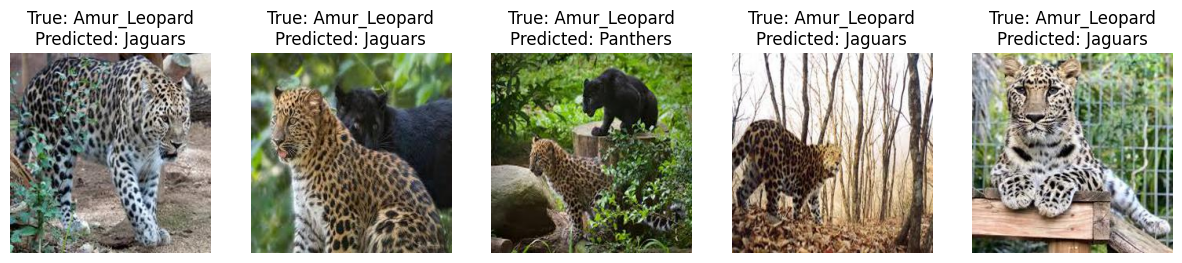

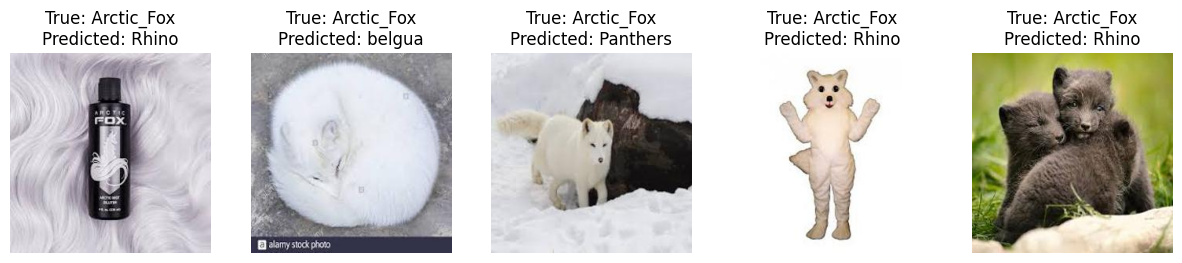

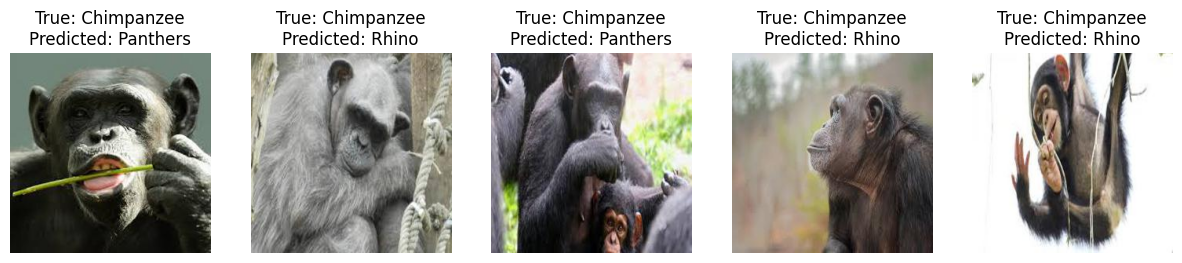

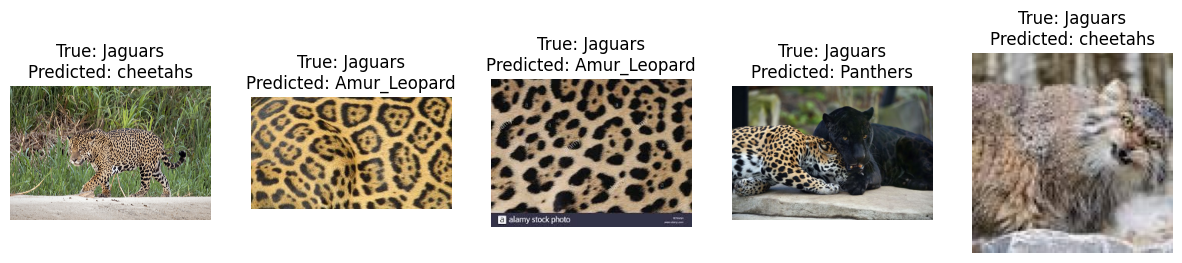

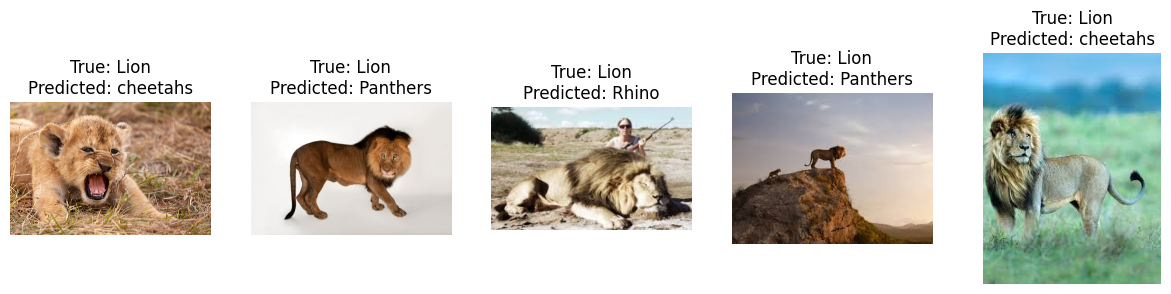

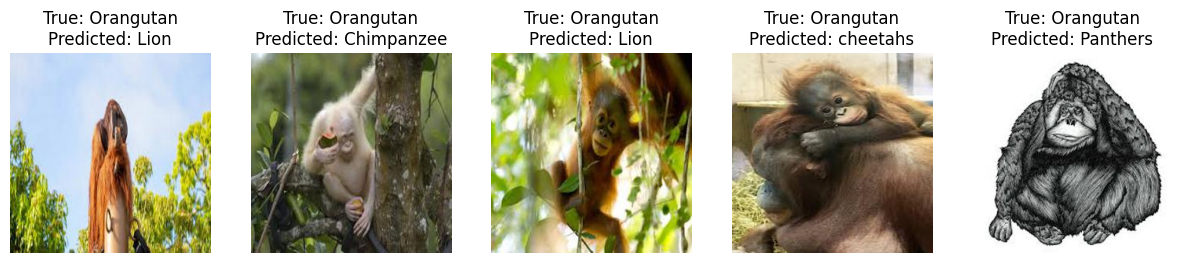

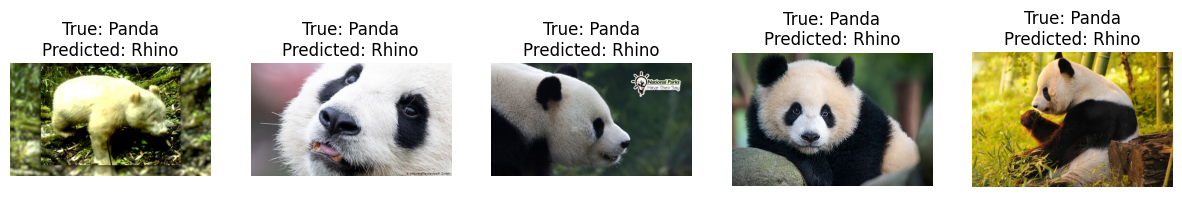

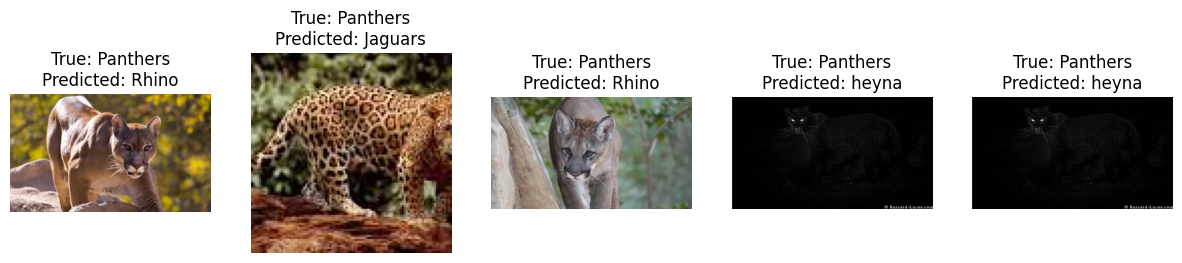

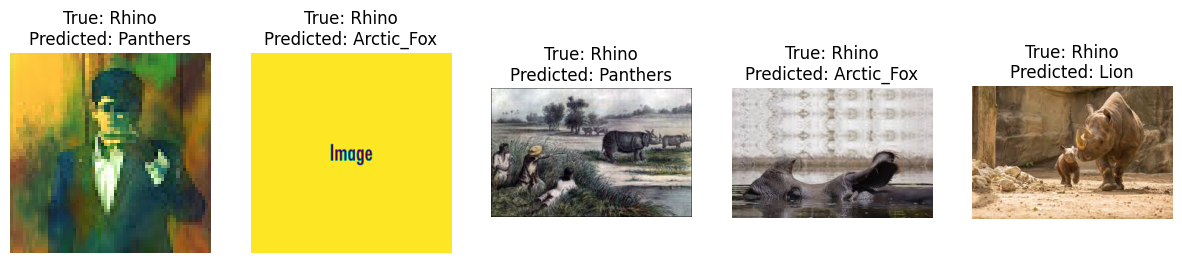

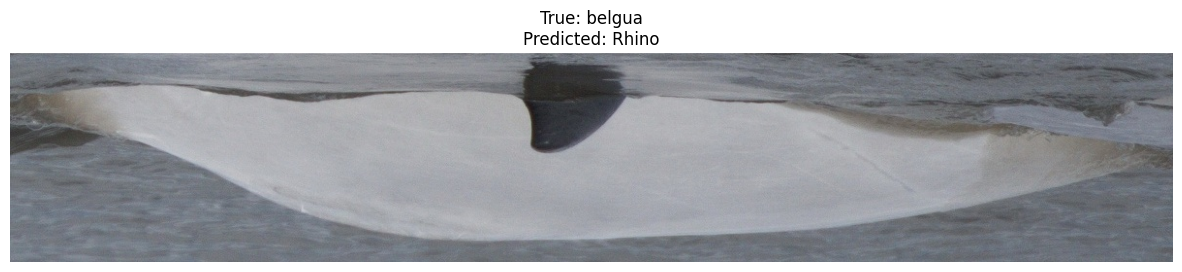

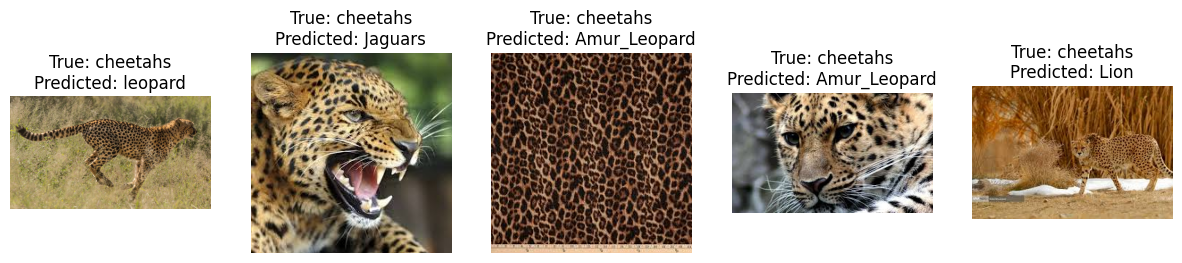

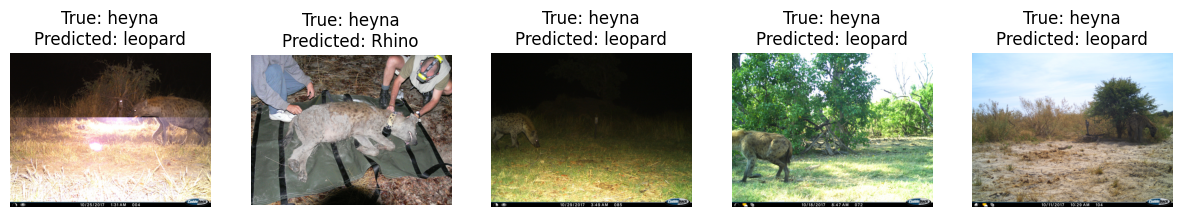

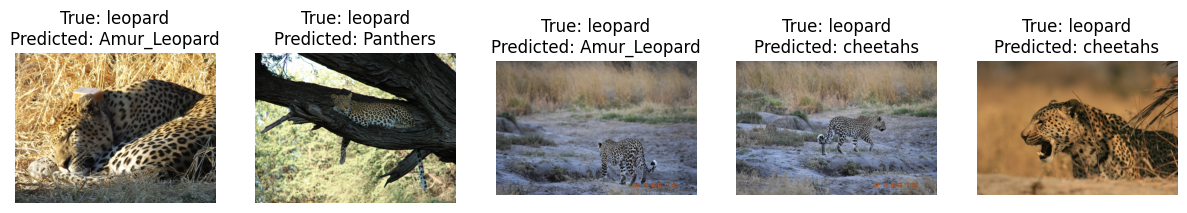

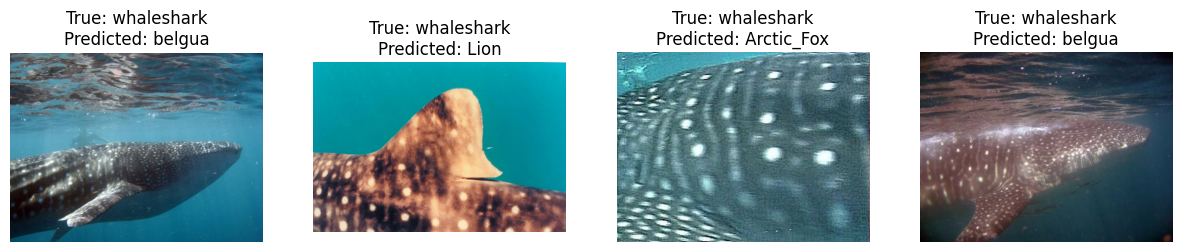

In [14]:
# Get the true labels
true_labels = test_generator.classes

# Get the predicted labels
predicted_labels = model_3.predict(test_generator).argmax(axis=1)

# Find incorrectly classified indices
incorrectly_classified_indices = np.where(true_labels != predicted_labels)[0]

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Display incorrectly classified images for each class
num_images_per_class = 5

for i in range(len(class_labels)):
    class_indices = np.where((true_labels == i) & (predicted_labels != i))[0]
    incorrect_indices_class = np.intersect1d(class_indices, incorrectly_classified_indices)

    if len(incorrect_indices_class) > 0:
        num_images_to_show = min(num_images_per_class, len(incorrect_indices_class))
        plt.figure(figsize=(15, 3))

        for j, idx in enumerate(incorrect_indices_class[:num_images_to_show]):
            img_path = test_generator.filepaths[idx]
            img = plt.imread(img_path)

            plt.subplot(1, num_images_to_show, j + 1)
            plt.imshow(img)
            plt.title(f'True: {class_labels[i]}\nPredicted: {class_labels[predicted_labels[idx]]}')
            plt.axis('off')

        plt.show()


Again using val acc as earlystoping measure: 

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Specify the path where you want to save the model weights
checkpoint_path = 'densenet121_original_dataset_early_stopping_2_.h5'

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Use 'val_accuracy' for early stopping
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',  # Use 'val_accuracy' for model checkpoint
    mode='max',
    verbose=1
)

# Compile the model
model_3.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

# Train the model with early stopping
history = model_3.fit(
    train_generator,
    steps_per_epoch=num_of_train_samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=num_of_valid_samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/100
239/239 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.8563
Epoch 1: val_accuracy improved from -inf to 0.76828, saving model to densenet121_original_dataset_early_stopping_2_.h5
239/239 [==============================] - 133s 506ms/step - loss: 0.6873 - accuracy: 0.8563 - val_loss: 0.9777 - val_accuracy: 0.7683
Epoch 2/100
239/239 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.8639
Epoch 2: val_accuracy did not improve from 0.76828
239/239 [==============================] - 119s 497ms/step - loss: 0.6531 - accuracy: 0.8639 - val_loss: 1.5463 - val_accuracy: 0.6486
Epoch 3/100
239/239 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.8757
Epoch 3: val_accuracy did not improve from 0.76828
239/239 [==============================] - 121s 507ms/step - loss: 0.5873 - accuracy: 0.8757 - val_loss: 1.0568 - val_accuracy: 0.7304
Epoch 4/100
239/239 [==============================] - ETA: 0s - loss: 0.5960 - acc

94/94 [==============================] - 25s 270ms/step - loss: 0.2704 - accuracy: 0.9441
Test Accuracy: 94.41%


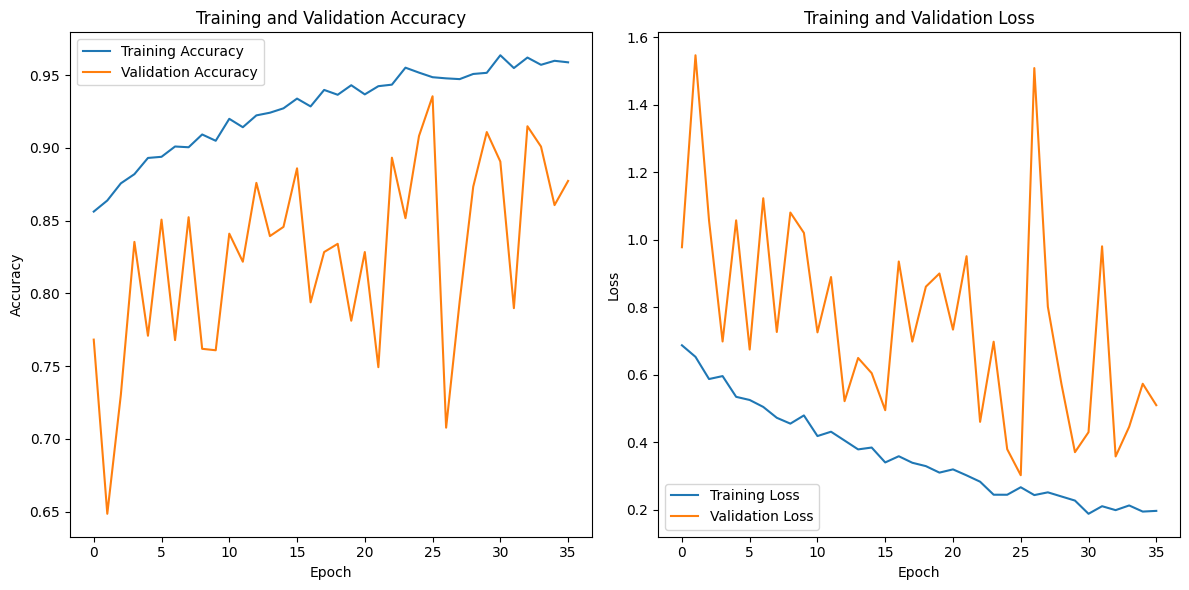

In [19]:
# Evaluate the model on the test data
test_steps = num_of_valid_samples // batch_size
evaluation = model_3.evaluate(test_generator, steps=test_steps)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [20]:
# Predict the classes for the entire test set
y_pred = model_3.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels for the entire test set
y_true_classes = test_generator.classes

# Generate and print the classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=train_generator.class_indices)
print("Classification Report:\n", class_report)


95/95 [==============================] - 27s 268ms/step
Classification Report:
               precision    recall  f1-score   support

Amur_Leopard       0.86      0.95      0.90       199
  Arctic_Fox       0.88      0.98      0.93       135
  Chimpanzee       0.97      0.99      0.98       166
     Jaguars       0.94      0.87      0.90       209
        Lion       0.92      0.94      0.93       271
   Orangutan       0.99      0.89      0.94       179
       Panda       0.99      0.95      0.97       280
    Panthers       0.91      0.96      0.94       200
       Rhino       0.96      0.94      0.95       259
      belgua       1.00      1.00      1.00       230
    cheetahs       0.86      0.95      0.90       211
       heyna       0.94      0.97      0.96       230
     leopard       0.99      0.86      0.92       230
  whaleshark       1.00      0.99      0.99       230

    accuracy                           0.94      3029
   macro avg       0.94      0.95      0.94      3029


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes for the entire test set
y_pred = model_3.predict(test_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels for the entire test set
y_true_classes = test_generator.classes

# Find misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)

95/95 [==============================] - 25s 267ms/step
[[189   0   0   5   0   0   1   1   0   0   3   0   0   0]
 [  0 132   0   0   0   0   1   1   0   1   0   0   0   0]
 [  0   0 164   0   1   0   0   1   0   0   0   0   0   0]
 [ 12   0   0 181   1   0   0   7   0   0   8   0   0   0]
 [  2   4   0   0 255   0   1   1   3   0   4   1   0   0]
 [  0   0   5   0  10 159   0   2   2   0   0   1   0   0]
 [  0   4   0   1   3   1 266   0   3   0   1   1   0   0]
 [  1   0   0   2   0   0   0 193   1   0   0   3   0   0]
 [  3   5   0   0   3   0   0   2 243   0   2   1   0   0]
 [  0   1   0   0   0   0   0   0   0 229   0   0   0   0]
 [  4   3   0   2   1   0   0   0   0   0 201   0   0   0]
 [  1   1   0   0   0   0   0   1   1   0   0 224   2   0]
 [  6   0   0   1   1   0   0   1   0   0  16   7 198   0]
 [  1   0   0   0   1   0   0   1   0   0   0   0   0 227]]
